In [2]:
import pretty_midi as pm
import matplotlib.pyplot as plt
import midi_processing
from importlib import reload

reload(midi_processing)

dat2mid_anna=midi_processing.dat2mid_anna

# function to midi image
def midi_image(tokens):
    # read in midi file
    midi_data=dat2mid_anna(tokens+[])
    # get piano roll
    piano_roll =  midi_data.get_piano_roll(fs=100) # shape=(pitch, timestep)
    # plot the piano roll with length of yaxis=xaxis
    
    plt.imshow(piano_roll, aspect='auto', origin='lower')
    plt.show()


In [3]:
# read pickle data_file 
import pickle
print("Reading data from pickle file...")
with open("Store/asap-dataset/train_data.pickle", 'rb') as f:
    data=pickle.load(f)
print("Completed reading")

Reading data from pickle file...
Completed reading


In [4]:
from collections import Counter
from datasets import Dataset,key_mapping,PAD_IDX,MASK_IDX,tok_mapping
import json
import random
import torch
from midi_processing import MidiToken
import pickle
import pandas as pd
import random 

random.seed(42)

class MidiMaskDataset(Dataset):
    '''
    MIDI sequences used in Music Transformer prepared for BERT-style training.
    Data augmentation includes pitch transpose and time stretch.
    The tokens are encoded as follows:
      0-127 = NOTE_ON
    128-255 = NOTE_OFF
    256-355 = TIME_SHIFT
    356-387 = SET_VELOCITY
    388-389 = START/STOP
        390 = MASK
        391 = PADDING
    '''
    def __init__(self, data_file, seq_len=512, mask_probs=[0.12, 0.015, 0.015]):
        self.seq_len = seq_len
        self.mask_probs = mask_probs

        self.data_file=data_file
        self.data=data

        # # read pickle data_file 
        # print("Reading data from pickle file...")
        # with open(data_file, 'rb') as f:
        #     self.pairs=pickle.load(f)
        # print("Completed reading")
        
        for performance_filename,pair in self.data.items():
            score_token_list=pair[0]
            performance_token_list=pair[1]

            # insert Start tokens
            score_token_list[0].insert(0, MidiToken("START", 0))
            performance_token_list[0].insert(0, MidiToken("START", 0))

            # insert Stop tokens
            score_token_list[-1].append(MidiToken("STOP", 0))
            performance_token_list[-1].append(MidiToken("STOP", 0))

            # Update self.data
            self.data[performance_filename]=(score_token_list,performance_token_list)

        self.num_songs = len(self.data)
        self.beats = torch.tensor([len(song) for song in self.data.values()])
        self.files=list(self.data.keys())

    def augment(self, seq):
        # data augmentation: pitch transposition
        pitch_change = random.randint(-3,3)
        seq = [MidiToken(tok.type, tok.value + pitch_change) if tok.type in ("NOTE_ON", "NOTE_OFF") else tok for tok in seq]
        # data augmentation: time stretch
        time_stretch = random.choice([0.95, 0.975, 1.0, 1.025, 1.05])
        seq = [MidiToken(tok.type, int(min(max((((time_stretch * tok.value) + 5) // 10) * 10, 10), 1000))) if tok.type == "TIME_SHIFT" else tok for tok in seq]
        return seq

    def end_beat(self,pair, start_beat):

        score_token_list,performance_token_list=pair

        # convert to lists
        score_token_list=list(score_token_list)
        performance_token_list=list(performance_token_list)

        assert len(score_token_list)==len(performance_token_list)

        # try using performance_token_list and find the end beat where joined token list length exceeds seq_len
        length_performance_section=len(performance_token_list[start_beat])
        length_score_section=len(score_token_list[start_beat])

        end_beat=start_beat

        # return the end_beat such that none of the lengths of the performance and score sections are greater than seq_len
        while max(length_performance_section,length_score_section)<self.seq_len:
            end_beat+=1
            length_performance_section+=len(performance_token_list[end_beat])
            length_score_section+=len(score_token_list[end_beat])

            if end_beat==len(performance_token_list)-1:
                break
            
            
        return(end_beat-1)
            

    def get_batch(self, batch_size,show=False): 
        # chooses what songs we're going to use in this batch
        song_indices = torch.multinomial(torch.ones(self.num_songs), batch_size)

        # for each song in the batch, choose a random starting beat less than the length of the song
        start_beats = [random.randint(0, int(0.75*self.beats[song_index])) for song_index in song_indices]

        # iterate over song index pairs and construct end_beats
        end_beats = list(range(batch_size))

        for i in range(batch_size):
            file=self.files[song_indices[i]]
            pair=self.data[file]
            start_beat=start_beats[i]

            end_beats[i]=self.end_beat(pair,start_beat)

        # Get score and performance tokens using start_beats and end_beats
        score_tokens = []
        performance_tokens = []
        differences=[]
        for i in range(batch_size):
            # get sections
            file=self.files[song_indices[i]]
            score,performance=self.data[file]


            score_section=score[start_beats[i]:end_beats[i]+1]
            performance_section=performance[start_beats[i]:end_beats[i]+1]

           # join all sublists of score_section and performance_section
            score_section=sum(score_section,[])
            performance_section=sum(performance_section,[])

            # pad sections to seq_len if necessary
            if len(score_section)<self.seq_len:
                score_section=score_section+[MidiToken("PADDING",0)]*(self.seq_len-len(score_section))

            if len(performance_section)<self.seq_len:
                performance_section=performance_section+[MidiToken("PADDING",0)]*(self.seq_len-len(performance_section))

            # compare score and performance sections
            diff=self.compare(score_section,performance_section)
            differences.append(diff)
            
            if show:
                # plot score and performance sections
                midi_image(score_section)
                midi_image(performance_section)

                # save midi files
                score_midi=dat2mid_anna(score_section+[])
                performance_midi=dat2mid_anna(performance_section+[])
                score_midi.write('score_midi.mid')
                performance_midi.write('performance_midi.mid')

            
            # Convert tokens to integers using key_mapping
            score_section=[key_mapping(tok) for tok in score_section]
            performance_section=[key_mapping(tok) for tok in performance_section]


            # Add to score_tokens and performance_tokens
            score_tokens.append(score_section)
            performance_tokens.append(performance_section)

        # Score tensor of shape (batch_size, seq_len)
        score_tensor = torch.tensor(score_tokens)
        # Performance tensor of shape (batch_size, seq_len)
        performance_tensor = torch.tensor(performance_tokens)
        # Difference tensor of shape (batch_size,1)
        difference_tensor = torch.tensor(differences)

        # Construct Input
        inp = score_tensor
        
        # Construct Output
        tgt = performance_tensor

        # assert that shape of inp and tgt are (batch_size, seq_len)
        assert inp.shape == (batch_size, self.seq_len)
        assert tgt.shape == (batch_size, self.seq_len)

        return {
            "inp": inp,
            "tgt": tgt,
            "diff": difference_tensor
        }
    def compare(self,score_section,performance_section):
        # loop through score_section and make a list of midi tokens of type NOTE_ON
        score_note_on_list=[]
        for tok in score_section:
            if tok.type=="NOTE_ON":
                score_note_on_list.append(tok.value)
        # loop through performance_section and make a list of midi tokens of type NOTE_ON
        performance_note_on_list=[]
        for tok in performance_section:
            if tok.type=="NOTE_ON":
                performance_note_on_list.append(tok.value)

        # sort both lists
        score_note_on_list.sort()
        performance_note_on_list.sort()

        # get counts of elements in both lists
        score_note_on_counts=Counter(score_note_on_list)
        performance_note_on_counts=Counter(performance_note_on_list)

        # get the difference between the two lists
        score_note_on_diff=score_note_on_counts-performance_note_on_counts

        # add all counts
        score_note_on_diff_sum=sum(score_note_on_diff.values())
        
        return score_note_on_diff_sum,score_note_on_diff_sum/len(score_section)*100
        
        


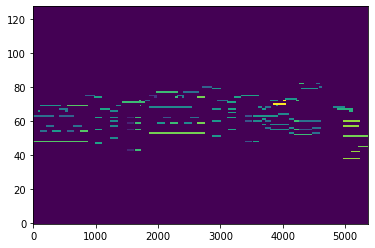

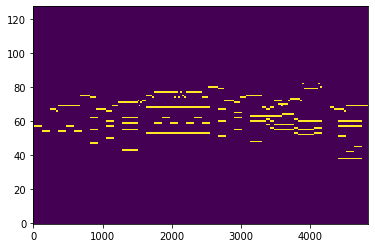

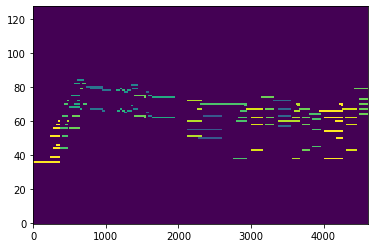

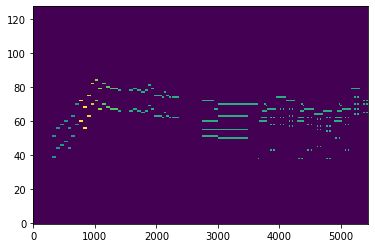

tensor([[8.0000, 1.5625],
        [2.0000, 0.3906]])


In [7]:
data_file="Store/asap-dataset/train_data.pickle"
dataset = MidiMaskDataset(data_file)
batch = dataset.get_batch(2,show=True)
# print diffrence between score and performance
print(batch["diff"])